Hasil fitting Voigt:
Amplitudo Lorentzian = 1.0358962593896182
Pusat (x_0) = 558.8676 nm
FWHM Lorentzian = 0.1200 nm
FWHM Gaussian = 0.0498 nm
FWHM Voigt = 0.1390 nm
Densitas elektron = 1.92e+17 cm^-3


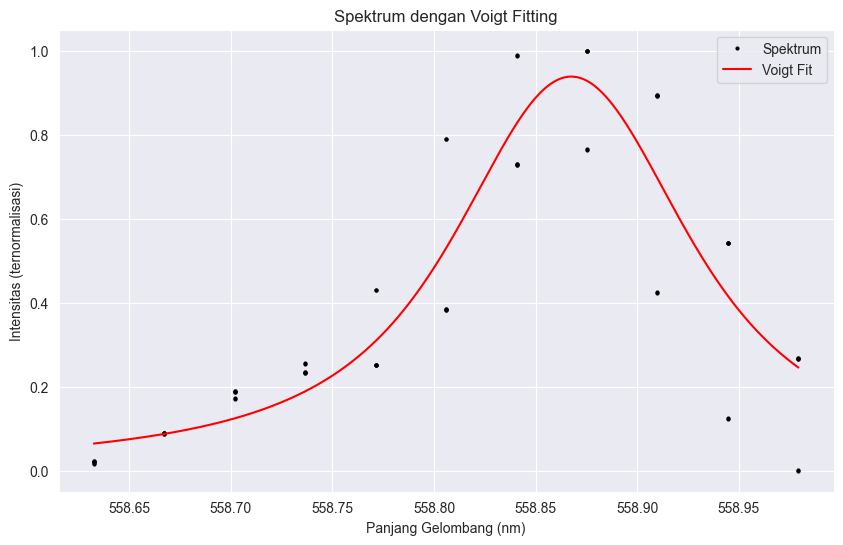

In [13]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from scipy.special import wofz

def calculate_voigt_fwhm(sigma, gamma):
    fwhm = 0.5346 * (2 * gamma) + np.sqrt(0.2166 * (2 * gamma)**2 + (2.355 * sigma)**2)
    return fwhm

def calculate_plasma_density(fwhm_stark, stark_broadening_parameter):
    if stark_broadening_parameter == 0:
        return None
    electron_density = ((fwhm_stark / (2 * stark_broadening_parameter)) ** (3/2)) * 1e17
    return electron_density

def voigt_fitting_with_fwhm_and_density(db_processed, sample_name, line_wavelength, stark_broadening_parameter):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, baseline_subtracted_signal
        FROM baseline_corrected_spectrum
        WHERE sample_name = ? AND iteration = 1
        AND wavelength BETWEEN ? AND ?
        ORDER BY wavelength
    """
    search_width = 0.2
    cursor.execute(query, (sample_name, line_wavelength - search_width, line_wavelength + search_width))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name} near wavelength: {line_wavelength}")
        return None, None, None

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)

    # Menormalisasi intensitas
    intensities = intensities - np.min(intensities)
    intensities = intensities / np.max(intensities)

    # Inisialisasi model Voigt1D dari Astropy
    voigt_model = models.Voigt1D(x_0=line_wavelength, amplitude_L=1.0, fwhm_L=0.1, fwhm_G=0.1)

    # Membuat fitter
    fitter = fitting.LevMarLSQFitter()

    # Melakukan fitting
    with np.errstate(all='ignore'):
        fitted_voigt = fitter(voigt_model, wavelengths, intensities)

    # Mengambil parameter hasil fitting
    amp_L = fitted_voigt.amplitude_L.value
    x_0 = fitted_voigt.x_0.value
    fwhm_L = fitted_voigt.fwhm_L.value
    fwhm_G = fitted_voigt.fwhm_G.value

    # Menghitung FWHM Voigt dan densitas plasma
    fwhm_voigt = calculate_voigt_fwhm(fwhm_G / 2.355, fwhm_L / 2)
    electron_density = calculate_plasma_density(fwhm_voigt, stark_broadening_parameter)

    print(f"Hasil fitting Voigt:")
    print(f"Amplitudo Lorentzian = {amp_L}")
    print(f"Pusat (x_0) = {x_0:.4f} nm")
    print(f"FWHM Lorentzian = {fwhm_L:.4f} nm")
    print(f"FWHM Gaussian = {fwhm_G:.4f} nm")
    print(f"FWHM Voigt = {fwhm_voigt:.4f} nm")
    print(f"Densitas elektron = {electron_density:.2e} cm^-3")

    plot_spectrum_with_fitting(wavelengths, intensities, fitted_voigt)

    return fitted_voigt, fwhm_voigt, electron_density

def plot_spectrum_with_fitting(wavelengths, intensities, fitted_voigt):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data asli sebagai titik hitam
    ax.plot(wavelengths, intensities, 'k.', label='Spektrum', markersize=4)

    # Plot hasil fitting sebagai garis merah
    wavelengths_fit = np.linspace(wavelengths.min(), wavelengths.max(), 1000)
    intensities_fit = fitted_voigt(wavelengths_fit)
    ax.plot(wavelengths_fit, intensities_fit, 'r-', label='Voigt Fit', linewidth=1.5)

    # Menyesuaikan tampilan plot
    ax.set_title('Spektrum dengan Voigt Fitting')
    ax.set_xlabel('Panjang Gelombang (nm)')
    ax.set_ylabel('Intensitas (ternormalisasi)')
    ax.legend()
    ax.grid(True)

    # Menyimpan plot sebagai PNG
    plt.savefig('voigt_fitting_result.png', dpi=300, bbox_inches='tight')
    plt.show()

# Database and parameters
db_processed = 'processed_spectra.db'
sample_name = 'S2'
line_wavelength = 558.8
stark_broadening_parameter = 90 / 2000  


fitted_voigt, fwhm_voigt, electron_density = voigt_fitting_with_fwhm_and_density(
    db_processed, sample_name, line_wavelength, stark_broadening_parameter
)

Hasil fitting Voigt:
Amplitudo Lorentzian = 1.398389772983068
Pusat (x_0) = 558.8372 nm
FWHM Lorentzian = 0.0811 nm
FWHM Gaussian = 0.0804 nm
FWHM Voigt = 0.1322 nm
Densitas elektron = 4.92e+16 cm^-3


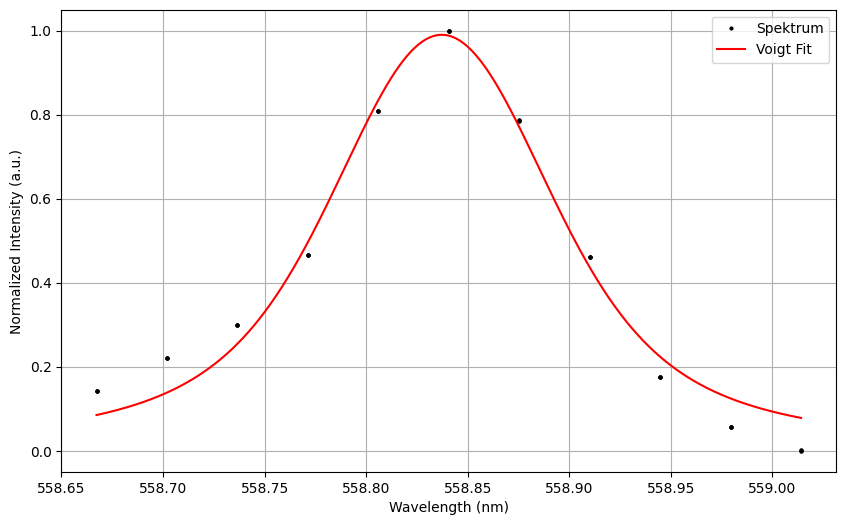

In [1]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

def calculate_voigt_fwhm(sigma, gamma):
    """Menghitung FWHM dari profil Voigt."""
    fwhm = 0.5346 * (2 * gamma) + np.sqrt(0.2166 * (2 * gamma)**2 + (2.355 * sigma)**2)
    return fwhm

def calculate_plasma_density(fwhm_voigt, omega):
    """Menghitung densitas elektron berdasarkan FWHM Voigt dan parameter omega."""
    if omega == 0:
        return None
    # Menggunakan rumus yang lebih tepat
    electron_density = ((fwhm_voigt / omega) ** 1.478) * 1e16  # Menghitung densitas elektron dalam cm^-3
    return electron_density


def voigt_fitting_with_fwhm_and_density(db_processed, sample_name, line_wavelength, stark_broadening_parameter):
    """Melakukan fitting Voigt dan menghitung densitas plasma."""
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, baseline_subtracted_signal
        FROM baseline_corrected_spectrum
        WHERE sample_name = ? AND iteration = 1
        AND wavelength BETWEEN ? AND ?
        ORDER BY wavelength
    """
    search_width = 0.2
    cursor.execute(query, (sample_name, line_wavelength - search_width, line_wavelength + search_width))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name} near wavelength: {line_wavelength}")
        return None, None, None

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)

    # Normalisasi intensitas
    intensities = intensities - np.min(intensities)
    intensities = intensities / np.max(intensities)

    # Inisialisasi model Voigt1D dari Astropy
    voigt_model = models.Voigt1D(x_0=line_wavelength, amplitude_L=1.0, fwhm_L=0.1, fwhm_G=0.1)

    # Membuat fitter
    fitter = fitting.LevMarLSQFitter()

    # Melakukan fitting
    with np.errstate(all='ignore'):
        fitted_voigt = fitter(voigt_model, wavelengths, intensities)

    # Mengambil parameter hasil fitting
    amp_L = fitted_voigt.amplitude_L.value
    x_0 = fitted_voigt.x_0.value
    fwhm_L = fitted_voigt.fwhm_L.value
    fwhm_G = fitted_voigt.fwhm_G.value

    # Menghitung FWHM Voigt
    fwhm_voigt = calculate_voigt_fwhm(fwhm_G / 2.355, fwhm_L / 2)

    # Mengonversi FWHM Voigt ke meter
    fwhm_voigt_m = fwhm_voigt * 1e-9  # Mengonversi dari nm ke m

    # Mengonversi parameter pelebaran Stark ke meter
    stark_broadening_parameter_m = stark_broadening_parameter * 1e-9  # Mengonversi dari nm ke m

    # Menghitung densitas plasma
    electron_density = calculate_plasma_density(fwhm_voigt_m, stark_broadening_parameter_m)

    print(f"Hasil fitting Voigt:")
    print(f"Amplitudo Lorentzian = {amp_L}")
    print(f"Pusat (x_0) = {x_0:.4f} nm")
    print(f"FWHM Lorentzian = {fwhm_L:.4f} nm")
    print(f"FWHM Gaussian = {fwhm_G:.4f} nm")
    print(f"FWHM Voigt = {fwhm_voigt:.4f} nm")
    print(f"Densitas elektron = {electron_density:.2e} cm^-3")

    plot_spectrum_with_fitting(wavelengths, intensities, fitted_voigt)

    return fitted_voigt, fwhm_voigt, electron_density

def plot_spectrum_with_fitting(wavelengths, intensities, fitted_voigt):
    """Membuat plot spektrum dengan hasil fitting Voigt."""
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data asli sebagai titik hitam
    ax.plot(wavelengths, intensities, 'k.', label='Spektrum', markersize=4)

    # Plot hasil fitting sebagai garis merah
    wavelengths_fit = np.linspace(wavelengths.min(), wavelengths.max(), 1000)
    intensities_fit = fitted_voigt(wavelengths_fit)
    ax.plot(wavelengths_fit, intensities_fit, 'r-', label='Voigt Fit', linewidth=1.5)

    # Menyesuaikan tampilan plot
    #ax.set_title('Spektrum dengan Voigt Fitting')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Normalized Intensity (a.u.)')
    ax.legend()
    ax.grid(True)

    # Menyimpan plot sebagai PNG
    plt.savefig('voigt_fitting_result.png', dpi=300, bbox_inches='tight')
    plt.show()

# Database and parameters
db_processed = 'processed_spectra.db'
sample_name = ('S3')
line_wavelength = 558.8370
stark_broadening_parameter = 90 / 2000  # nm

# Melakukan fitting dan menghitung densitas elektron
fitted_voigt, fwhm_voigt, electron_density = voigt_fitting_with_fwhm_and_density(
    db_processed, sample_name, line_wavelength, stark_broadening_parameter
)


In [ ]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tkinter import Tk, Button, Label, filedialog, StringVar, OptionMenu, messagebox, ttk, Frame
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import find_peaks

k_B = 8.617333262145e-5

def get_nist_data_for_wavelengths(db_nist, nist_wavelengths, element, sp_num):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    nist_data = []
    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ei(cm-1)", "gA(s^-1)"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ? AND "Element" = ? AND "sp_num" = ?
        """
        cursor.execute(query, (wl, element, sp_num))
        result = cursor.fetchone()
        if result:
            obs_wl, Ei, gA = result
            try:
                Ei = float(Ei) / 8065.544  # Convert cm^-1 to eV
                nist_data.append((obs_wl, Ei, float(gA)))
            except ValueError:
                print(f"Skipping invalid Ei value for wavelength {obs_wl}")
    conn.close()
    return nist_data

def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []

    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, baseline_subtracted_signal
            FROM baseline_corrected_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            peak_index, _ = find_peaks(intensities, height=max(intensities) * 0.5)
            if len(peak_index) == 0:
                integrated_intensities.append(None)
                continue

            peak_index = peak_index[0]
            left_min_index = np.argmin(intensities[:peak_index])
            right_min_index = np.argmin(intensities[peak_index:]) + peak_index

            integrated_area = np.trapz(intensities[left_min_index:right_min_index + 1], wavelengths[left_min_index:right_min_index + 1])
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)
    conn.close()
    return integrated_intensities

def calculate_temperature(nist_data, intensities, exp_wavelengths):
    energies = []
    boltzmann_values = []

    for i, (wl_nist, Ei, gA) in enumerate(nist_data):
        intensity = intensities[i]
        if intensity is None or gA == 0:
            continue

        boltzmann_value = np.log((intensity * exp_wavelengths[i]) / gA)
        energies.append(Ei)
        boltzmann_values.append(boltzmann_value)

    if len(boltzmann_values) < 2:
        print("Tidak cukup data untuk menghitung suhu plasma.")
        return None, None, None

    slope, intercept, _, _, _ = linregress(energies, boltzmann_values)
    T_plasma = -1 / (k_B * slope)
    return T_plasma, slope, energies, boltzmann_values

class PlasmaTemperatureApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Plasma Temperature Calculator")
        self.root.geometry("1000x600")  # Initial window size

        self.db_nist = "data1.db"
        self.db_processed = "processed_spectra.db"
        self.excel_file_path = None
        self.excel_data = None
        self.elements = []
        self.ion_stages = {}
        self.selected_element = StringVar()
        self.selected_ion_stage = StringVar()
        self.selected_sample = StringVar()
        self.selected_lines = []

        main_frame = Frame(self.root)
        main_frame.grid(row=0, column=0, sticky="nsew")
        main_frame.grid_rowconfigure(0, weight=1)
        main_frame.grid_columnconfigure(1, weight=3)

        self.setup_ui(main_frame)

    def setup_ui(self, frame):
        input_frame = Frame(frame)
        input_frame.grid(row=0, column=0, padx=10, pady=5, sticky="ns")
        input_frame.grid_rowconfigure(6, weight=1)

        load_button = Button(input_frame, text="Load Excel File", command=self.load_excel_file)
        load_button.grid(row=0, column=0, columnspan=2, pady=5, sticky="ew")

        Label(input_frame, text="Select Element:").grid(row=1, column=0, sticky="e")
        self.element_menu = OptionMenu(input_frame, self.selected_element, ())
        self.element_menu.grid(row=1, column=1, sticky="ew", pady=5)

        Label(input_frame, text="Select Ion Stage:").grid(row=2, column=0, sticky="e")
        self.ion_stage_menu = OptionMenu(input_frame, self.selected_ion_stage, ())
        self.ion_stage_menu.grid(row=2, column=1, sticky="ew", pady=5)

        Label(input_frame, text="Select Sample:").grid(row=3, column=0, sticky="e")
        sample_options = [f"S{i}" for i in range(1, 25)]
        self.selected_sample.set(sample_options[0])
        sample_menu = OptionMenu(input_frame, self.selected_sample, *sample_options)
        sample_menu.grid(row=3, column=1, sticky="ew", pady=5)

        show_table_button = Button(input_frame, text="Show Lines for Selection", command=self.show_line_table)
        show_table_button.grid(row=4, column=0, columnspan=2, pady=10, sticky="ew")

        calculate_button = Button(input_frame, text="Calculate Plasma Temperature", command=self.calculate_plasma_temperature)
        calculate_button.grid(row=5, column=0, columnspan=2, pady=10, sticky="ew")

        plot_frame = Frame(frame)
        plot_frame.grid(row=0, column=1, padx=10, pady=5, sticky="nsew")
        plot_frame.grid_rowconfigure(0, weight=1)
        plot_frame.grid_columnconfigure(0, weight=1)
        self.plot_frame = plot_frame
        self.canvas = None

        self.table_frame = Frame(frame)
        self.table_frame.grid(row=1, column=0, padx=10, pady=5, sticky="nsew")
        self.table_frame.grid_rowconfigure(0, weight=1)
        self.table_frame.grid_columnconfigure(0, weight=1)

        self.result_frame = Frame(frame)
        self.result_frame.grid(row=1, column=1, padx=10, pady=5, sticky="nsew")
        self.result_frame.grid_rowconfigure(0, weight=1)
        self.result_frame.grid_columnconfigure(0, weight=1)

    def load_excel_file(self):
        file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx")])
        if file_path:
            try:
                self.excel_file_path = file_path
                df = pd.read_excel(file_path)
                required_columns = ["Element", "Ion Stage", "NIST WL", "Exp Peak WL"]
                if not all(col in df.columns for col in required_columns):
                    raise ValueError("Excel file is missing required columns.")
                self.excel_data = df
                self.update_element_menu()
                messagebox.showinfo("Success", "Excel data loaded successfully.")
            except Exception as e:
                messagebox.showerror("Error", str(e))

    def update_element_menu(self):
        self.elements = self.excel_data["Element"].unique().tolist()
        self.ion_stages = {
            element: self.excel_data[self.excel_data["Element"] == element]["Ion Stage"].unique().tolist()
            for element in self.elements
        }

        self.element_menu["menu"].delete(0, "end")
        for element in self.elements:
            self.element_menu["menu"].add_command(label=element, command=lambda el=element: self.on_element_selected(el))

        if self.elements:
            self.selected_element.set(self.elements[0])
            self.on_element_selected(self.elements[0])

    def on_element_selected(self, element):
        self.selected_element.set(element)
        self.update_ion_stage_menu(element)

    def update_ion_stage_menu(self, element):
        ion_stages = self.ion_stages.get(element, [])
        self.ion_stage_menu["menu"].delete(0, "end")
        
        for ion_stage in ion_stages:
            self.ion_stage_menu["menu"].add_command(label=ion_stage, command=lambda ion=ion_stage: self.selected_ion_stage.set(ion))
        
        if ion_stages:
            self.selected_ion_stage.set(ion_stages[0])

    def show_line_table(self):
        selected_element = self.selected_element.get()
        selected_ion_stage = int(self.selected_ion_stage.get())

        line_data = self.excel_data[(self.excel_data["Element"] == selected_element) &
                                    (self.excel_data["Ion Stage"] == selected_ion_stage)]
        nist_wavelengths = line_data["NIST WL"].tolist()
        exp_wavelengths = line_data["Exp Peak WL"].tolist()

        integrated_intensities = get_integrated_intensity_with_min_bounds(self.db_processed, self.selected_sample.get(), exp_wavelengths)
        nist_data = get_nist_data_for_wavelengths(self.db_nist, nist_wavelengths, selected_element, selected_ion_stage)

        for widget in self.table_frame.winfo_children():
            widget.destroy()

        tree = ttk.Treeview(self.table_frame, columns=("NIST WL", "Exp WL", "Ei (eV)", "Integrated Intensity"), show="headings", selectmode="extended")
        tree.heading("NIST WL", text="NIST WL")
        tree.heading("Exp WL", text="Exp WL")
        tree.heading("Ei (eV)", text="Ei (eV)")
        tree.heading("Integrated Intensity", text="Integrated Intensity")

        for (nist_wl, Ei, gA), exp_wl, intensity in zip(nist_data, exp_wavelengths, integrated_intensities):
            tree.insert("", "end", values=(nist_wl, exp_wl, f"{Ei:.4f}" if Ei else "N/A", f"{intensity:.2f}" if intensity else "N/A"))
        
        tree.pack(fill="both", expand=True)
        
        select_button = Button(self.table_frame, text="Select Lines", command=lambda: self.select_lines(tree))
        select_button.pack(pady=5)

    def select_lines(self, tree):
        selected_items = tree.selection()
        self.selected_lines = [(tree.item(item)["values"][0], tree.item(item)["values"][1]) for item in selected_items]
        messagebox.showinfo("Selection", f"{len(self.selected_lines)} lines selected for temperature calculation.")

    def calculate_plasma_temperature(self):
        if not self.selected_lines:
            messagebox.showerror("Error", "No lines selected for calculation.")
            return

        nist_wavelengths = [float(line[0]) for line in self.selected_lines]
        exp_wavelengths = [float(line[1]) for line in self.selected_lines]

        element = self.selected_element.get()
        sp_num = int(self.selected_ion_stage.get())

        intensities = get_integrated_intensity_with_min_bounds(self.db_processed, self.selected_sample.get(), exp_wavelengths)
        nist_data = get_nist_data_for_wavelengths(self.db_nist, nist_wavelengths, element, sp_num)

        T_plasma, slope, energies, boltzmann_values = calculate_temperature(nist_data, intensities, exp_wavelengths)
        
        if T_plasma:
            messagebox.showinfo("Result", f"Suhu plasma: {T_plasma:.2f} K")
            self.plot_boltzmann_plot(energies, boltzmann_values, slope)
            self.display_results(T_plasma, slope)

    def plot_boltzmann_plot(self, energies, boltzmann_values, slope):
        if self.canvas:
            self.canvas.get_tk_widget().pack_forget()
    
        fig, ax = plt.subplots(figsize=(10, 6))
        
        intercept = boltzmann_values[0] - slope * energies[0]
        ax.scatter(energies, boltzmann_values, color='red', s=10, label="Data Points")
        ax.plot(energies, slope * np.array(energies) + intercept, color='blue', label=f'Fit Line (Slope = {slope:.3f})')
        
        ax.set_xlabel('Excitation Energy (Ei) (eV)')
        ax.set_ylabel('ln(I * λ / gA)')
        ax.set_title('Boltzmann Plot')
        ax.legend()
        
        self.canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack()

root = Tk()
app = PlasmaTemperatureApp(root)
root.mainloop()

Data tidak ditemukan di database untuk: Element=Al, Ion Stage=1, NIST WL=396.152
  Available data -> Sim Peak WL: 396.1654, Exp WL: 396.1488, Exp Intensity: 0.361713, Einstein Coefficient: 197000000
Data tidak ditemukan di database untuk: Element=C, Ion Stage=1, NIST WL=247.8561
  Available data -> Sim Peak WL: 247.8596, Exp WL: 247.849, Exp Intensity: 0.006125, Einstein Coefficient: 84000000
Data tidak ditemukan di database untuk: Element=Cu, Ion Stage=1, NIST WL=324.754
  Available data -> Sim Peak WL: 324.7558, Exp WL: 324.8565, Exp Intensity: 0.006871, Einstein Coefficient: 558000000
Data tidak ditemukan di database untuk: Element=Eu, Ion Stage=2, NIST WL=390.71
  Available data -> Sim Peak WL: 390.7070219864143, Exp WL: 390.68475, Exp Intensity: 0.0046415231210385, Einstein Coefficient: 685000000
Data tidak ditemukan di database untuk: Element=Fe, Ion Stage=1, NIST WL=381.584
  Available data -> Sim Peak WL: 381.5909, Exp WL: 382.0324, Exp Intensity: 0.058765, Einstein Coefficient

Data tidak lengkap untuk Element=Ba, Ion Stage=2. Lewati perhitungan.
Data energi ionisasi untuk Eu dengan ion_stage 1 tidak ditemukan.
Data energi ionisasi untuk Pb dengan ion_stage 1 tidak ditemukan.
Konsentrasi total unsur dalam sampel (dalam persen):
Ag: 1.65%
Al: 7.91%
As: 0.01%
Br: 0.26%
C: 1.20%
Ca: 0.04%
Cl: 0.16%
Cu: 0.51%
Eu: 0.00%
Fe: 47.53%
Ga: 0.29%
H: 8.60%
K: 9.54%
Li: 4.27%
Mg: 0.23%
Mn: 0.00%
N: 0.40%
Na: 9.27%
Nd: 0.04%
O: 5.38%
P: 0.00%
Pb: 0.00%
Rb: 2.19%
Si: 0.01%
Sr: 0.05%
Ti: 0.08%
V: 0.02%
Y: 0.08%
Zn: 0.27%


In [11]:
import pandas as pd

# Fungsi untuk memuat data ionisasi dari CSV dan menyimpan data energi ionisasi ke Excel
def save_ionization_energy_to_excel_with_converted_ion_stage(csv_path, output_excel_path):
    # Load ionization data dari iona.csv
    ionization_data = pd.read_csv(csv_path)
    
    # Bersihkan data, hapus tanda kutip dan '=' di sekitar nilai
    ionization_data = ionization_data.apply(lambda col: col.map(lambda x: x.replace('"', '').strip('=') if isinstance(x, str) else x))
    
    # Ambil kolom yang relevan: elemen, ion charge, dan energi ionisasi
    ionization_energy_data = ionization_data[['Isoel. Seq.', 'Ion Charge', 'Ionization Energy (eV)']]
    
    # Ubah nama kolom dan konversi Ion Charge ke Ion Stage
    ionization_energy_data.columns = ['Element', 'Ion Charge', 'Ionization Energy (eV)']
    ionization_energy_data['Ion Stage'] = ionization_energy_data['Ion Charge'].apply(lambda x: 1 if x == '0' else 2 if x == '+1' else None)
    
    # Hapus kolom Ion Charge karena sudah digantikan dengan Ion Stage
    ionization_energy_data = ionization_energy_data[['Element', 'Ion Stage', 'Ionization Energy (eV)']]
    
    # Simpan data ke file Excel baru
    ionization_energy_data.to_excel(output_excel_path, index=False)
    print(f"Data energi ionisasi telah disimpan di {output_excel_path}")

# Path ke file CSV dan output file Excel
csv_path = "iona.csv"
output_excel_path = "ionization_energy_converted.xlsx"

# Jalankan fungsi untuk menyimpan data energi ionisasi ke Excel
save_ionization_energy_to_excel_with_converted_ion_stage(csv_path, output_excel_path)

Data energi ionisasi telah disimpan di ionization_energy_converted.xlsx


/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_24134/1288792151.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ionization_energy_data['Ion Stage'] = ionization_energy_data['Ion Charge'].apply(lambda x: 1 if x == '0' else 2 if x == '+1' else None)


In [1]:
import pandas as pd

# Path ke file Excel Anda
excel_path = "S1.xlsx"  # Ganti dengan path yang sesuai jika berbeda

# Muat data dari Excel
df = pd.read_excel(excel_path)

# Cari baris yang memiliki duplikat di kolom 'NIST WL' dan ambil salah satu dari setiap grup duplikat
duplicates_one = df[df.duplicated(subset='NIST WL', keep='first')]

# Hapus salah satu dari setiap grup duplikat dari sheet asal
df_cleaned = df.drop(duplicates_one.index)

# Tulis hasil ke dalam file Excel baru, dengan sheet asal yang telah dibersihkan dan sheet "Duplicates" untuk duplikat
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    df_cleaned.to_excel(writer, sheet_name="Sheet3", index=False)  # Ganti "Sheet1" dengan nama sheet asal jika berbeda
    duplicates_one.to_excel(writer, sheet_name="Duplicates1", index=False)
    
print("Salah satu baris dari setiap pasangan duplikat telah dipindahkan ke sheet 'Duplicates' dan dihapus dari sheet asal.")

Salah satu baris dari setiap pasangan duplikat telah dipindahkan ke sheet 'Duplicates' dan dihapus dari sheet asal.


In [8]:
import numpy as np
import pandas as pd
import sqlite3

k_B = 8.617333262145e-5
m_e = 9.10938356e-31
h = 6.62607015e-34

def load_ionization_data(excel_path):
    ionization_data = pd.read_excel(excel_path)
    return ionization_data

ionization_energy_cache = {}

def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan di file ionization_energy_converted.xlsx.")
        ionization_energy_cache[key] = None
        return None

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent

def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []

    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.1
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            intensities = np.array(intensities)
            if len(intensities) == 0 or np.all(intensities == 0):
                integrated_intensities.append(None)
                continue

            peak_index = np.argmax(intensities)
            left_min_index = np.argmin(intensities[:peak_index]) if peak_index > 0 else 0
            right_min_index = np.argmin(intensities[peak_index:]) + peak_index if peak_index < len(intensities) - 1 else len(intensities) - 1

            integrated_area = np.trapz(intensities[left_min_index:right_min_index + 1], wavelengths[left_min_index:right_min_index + 1])
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)

    conn.close()
    return integrated_intensities

def load_spectral_data_from_excel(s1_a_path, db_processed, sample_name):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "NIST WL", "Einstein Coefficient", "Exp Peak WL", "Exp Intensity", "gi", "gk", "Ei (cm-1)", "Ek (cm-1)"]
    df = pd.read_excel(s1_a_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    exp_wavelengths = df["Exp Peak WL"].tolist()
    intensities = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths)

    spectral_data = []
    for (_, row), intensity in zip(df.iterrows(), intensities):
        element = row["Element"]
        ion_stage = row["Ion Stage"]
        exp_wl = row["Exp Peak WL"]
        gA = row["Einstein Coefficient"]
        gi = row["gi"]
        gk = row["gk"]
        Ei = row["Ei (cm-1)"]
        Ek = row["Ek (cm-1)"]
        Ek_in_eV = Ek / 8065.544 if Ek else None

        data_entry = {
            "Element": element,
            "Ion Stage": ion_stage,
            "Exp WL": exp_wl,
            "Intensity": intensity,  # Use integrated intensity
            "Einstein Coefficient": gA,
            "gi": gi,
            "gk": gk,
            "Ei (cm-1)": Ei,
            "Ek (eV)": Ek_in_eV
        }

        spectral_data.append(data_entry)
    
    return spectral_data

def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []

    for data in spectral_data:
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Intensity"]
        wl = data["Exp WL"]
        E_u = data.get("Ek (eV)")
        Aki = data.get("Einstein Coefficient")

        if E_u is None or Aki is None:
            print(f"Data tidak lengkap untuk Element={element}, Ion Stage={ion_stage}. Lewati perhitungan.")
            continue

        Z_neutral = np.exp(-E_u / (k_B * T_e))
        N_rel = (intensity * wl) / (Aki * np.exp(-E_u / (k_B * T_e))) if Aki else 0
        neutral_concentration = N_rel

        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            Z_ion = np.exp(-E_u / (k_B * T_e))
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * neutral_concentration
            total_concentration = neutral_concentration + ion_concentration
        else:
            total_concentration = neutral_concentration

        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration

        overall_concentration += total_concentration

        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "Exp WL": wl,
            "Intensity": intensity,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration  # Simpan nilai awal
        })

    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100

    # Perbarui Total Concentration di detailed_data menjadi persen
    for row in detailed_data:
        element = row["Element"]
        row["Total Concentration"] = (row["Total Concentration"] / overall_concentration) * 100

    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data.xlsx", index=False)

    return total_concentrations

# Load data
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")
s1_a_path = 'S1_a.xlsx'
db_processed = 'processed_spectra.db'
sample_name = 'S1'

spectral_data = load_spectral_data_from_excel(s1_a_path, db_processed, sample_name)

# Calculate concentrations
T_e = 11963.46126
n_e = 2.73e+17
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

# Display results
print("Konsentrasi total unsur dalam sampel (dalam persen):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.20f}%")

Konsentrasi total unsur dalam sampel (dalam persen):
Ag: nan%
Al: nan%
Ba: nan%
C: nan%
Ca: nan%
Cu: nan%
Fe: nan%
H: nan%
K: nan%
Li: nan%
Mg: nan%
Mn: nan%
N: nan%
Nd: nan%
O: nan%
Si: nan%
Sr: nan%
Ti: nan%
V: nan%
Na: nan%


In [4]:
import sqlite3
import pandas as pd

def export_data_for_sp_num_to_excel(db_path, sp_nums, output_file):
    """
    Export data for specific sp_num values (e.g., 1 and 2) from data1.db to an Excel file.
    """
    conn = sqlite3.connect(db_path)
    
    # Create the SQL query with placeholders for sp_num values
    query = f"""
        SELECT *
        FROM spectrum_data
        WHERE sp_num IN ({','.join(['?'] * len(sp_nums))})
    """
    
    # Execute the query with sp_num parameters
    df = pd.read_sql_query(query, conn, params=sp_nums)
    conn.close()
    
    if df.empty:
        print(f"No data found for sp_num values: {sp_nums}")
    else:
        # Export data to Excel
        df.to_excel(output_file, index=False)
        print(f"Data has been exported to {output_file}")

# Replace 'data1.db' with the path to your database and specify the desired output file name
db_path = 'data1.db'
output_file = 'sp_num_1_and_2_data.xlsx'

# sp_num values for filtering
sp_nums = [1, 2]

# Run the function to export data
export_data_for_sp_num_to_excel(db_path, sp_nums, output_file)

Data has been exported to sp_num_1_and_2_data.xlsx


In [1]:
import pandas as pd
import sqlite3

def excel_to_sqlite(excel_path, db_path, table_name="a"):
    """
    Convert an Excel file to a SQLite database.
    
    Parameters:
    - excel_path: Path to the input Excel file (e.g., "data1.xlsx")
    - db_path: Path to the output SQLite database (e.g., "data1.db")
    - table_name: Name of the table to create in the database
    """
    # Load data from Excel
    df = pd.read_excel(excel_path)
    
    # Connect to SQLite database (it will create a new one if it doesn't exist)
    conn = sqlite3.connect(db_path)
    
    # Write the DataFrame to a SQL table in the SQLite database
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Close the connection
    conn.close()
    print(f"Data from {excel_path} has been saved to {db_path} as table '{table_name}'.")

# Specify paths for the Excel file and output database
excel_path = "data1.xlsx"      # Path to your Excel file
db_path = "data2.db"       # Path for the new SQLite database

# Run the function to convert Excel to SQLite
excel_to_sqlite(excel_path, db_path)

Data from data1.xlsx has been saved to data2.db as table 'a'.


In [1]:
import pandas as pd

# Load the Excel file
excel_path = "data1.xlsx"  # Replace with your Excel file path
df = pd.read_excel(excel_path)

# Convert columns to string for accurate comparison
df['NIST WL'] = df['NIST WL'].astype(str)
df['obs_wl_air(nm)'] = df['obs_wl_air(nm)'].astype(str)

# Check and copy values if 'NIST WL' is equal to 'obs_wl_air(nm)'
for index, row in df.iterrows():
    if row['NIST WL'] == row['obs_wl_air(nm)']:
        # Copy values from source columns to target columns
        df.at[index, 'gi'] = row['g_i']
        df.at[index, 'gk'] = row['g_k']
        df.at[index, 'Ei'] = row['Ei(cm-1)']
        df.at[index, 'Ek'] = row['Ek(cm-1)']

# Save the updated DataFrame to a new Excel file
output_path = "updated_S11.xlsx"
df.to_excel(output_path, index=False)
print(f"Data has been saved to {output_path}")

Data has been saved to updated_S11.xlsx


In [2]:
import pandas as pd
import sqlite3

def fetch_additional_data(db_path, element, ion_stage, nist_wavelength, tolerance=0.001):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Query untuk mengambil data berdasarkan elemen, ion stage, dan panjang gelombang dalam toleransi
    query = """
        SELECT g_i, g_k, "Ei(cm-1)", "Ek(cm-1)", "gA(s^-1)"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ? AND ABS("obs_wl_air(nm)" - ?) < ?
    """
    cursor.execute(query, (element, ion_stage, nist_wavelength, tolerance))
    result = cursor.fetchone()
    conn.close()
    
    if result:
        g_i, g_k, Ei_cm1, Ek_cm1, gA = result
        
        # Bersihkan tanda kurung jika ada, dan konversi ke float
        try:
            Ei = float(str(Ei_cm1).strip('[]')) * 0.000123984 if Ei_cm1 not in (None, '') else None
            Ek = float(str(Ek_cm1).strip('[]')) * 0.000123984 if Ek_cm1 not in (None, '') else None
        except ValueError:
            Ei, Ek = None, None  # Set None jika konversi gagal

        return g_i, g_k, Ei, Ek, gA
    else:
        return None, None, None, None, None

def complete_excel_with_db_data(excel_path, db_path, output_path):
    df = pd.read_excel(excel_path)

    # Tambahkan kolom baru untuk gi, gk, Ei, Ek, dan Einstein Coefficient
    df['gi'] = None
    df['gk'] = None
    df['Ei (eV)'] = None
    df['Ek (eV)'] = None
    df['Einstein Coefficient'] = None

    # Iterasi pada setiap baris dan perbarui data berdasarkan Element, Ion Stage, dan NIST WL
    for index, row in df.iterrows():
        element = row['Element']
        ion_stage = row['Ion Stage']
        nist_wl = row['NIST WL']
        
        if pd.notna(nist_wl) and pd.notna(element) and pd.notna(ion_stage):
            gi, gk, Ei, Ek, gA = fetch_additional_data(db_path, element, ion_stage, nist_wl)
            df.at[index, 'gi'] = gi
            df.at[index, 'gk'] = gk
            df.at[index, 'Ei (eV)'] = Ei
            df.at[index, 'Ek (eV)'] = Ek
            df.at[index, 'Einstein Coefficient'] = gA

    # Simpan DataFrame hasil ke file Excel baru
    df.to_excel(output_path, index=False)
    print(f"Data lengkap telah disimpan ke {output_path}")

# Jalankan fungsi dengan path ke file Excel, database, dan output file
excel_path = 'fixb.xlsx'  # Ganti dengan path ke file Excel Anda
db_path = 'data1.db'  # Ganti dengan path ke database Anda
output_path = 'fixc.xlsx'  # Ganti dengan path output yang diinginkan

complete_excel_with_db_data(excel_path, db_path, output_path)

Data lengkap telah disimpan ke fixc.xlsx


In [22]:
import numpy as np
import pandas as pd
import sqlite3

# Constants
k_B = 8.617333262145e-5  # eV/K
m_e = 9.10938356e-31  # kg
h = 6.62607015e-34  # J*s

def load_ionization_data(excel_path):
    return pd.read_excel(excel_path)

ionization_energy_cache = {}

def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan.")
        ionization_energy_cache[key] = None
        return None

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent
def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []
    
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, baseline_subtracted_signal
            FROM baseline_corrected_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.08 # Sesuaikan berdasarkan resolusi spektrometer
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()
    
        if results:
            wavelengths, intensities = zip(*results)
            wavelengths = np.array(wavelengths)
            intensities = np.array(intensities)
            
            # Mengurangi latar belakang
            background = np.min(intensities)
            intensities -= background
            
            # Integrasi menggunakan metode trapezoidal
            integrated_area = np.trapz(intensities, wavelengths)
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)
    
    conn.close()
    return integrated_intensities
def identify_non_overlapping_lines(df, min_separation=0.1):
    df = df.reset_index(drop=True)
    non_overlapping_indices = []
    wavelengths = df["Exp Peak WL"].values
    elements = df["Element"].values
    
    for i in range(len(df)):
        wl_i = wavelengths[i]
        element_i = elements[i]
        overlapping = False
        for j in range(len(df)):
            if i != j:
                wl_j = wavelengths[j]
                element_j = elements[j]
                if abs(wl_i - wl_j) < min_separation and element_i != element_j:
                    overlapping = True
                    break
        if not overlapping:
            non_overlapping_indices.append(i)
    
    df_non_overlapping = df.iloc[non_overlapping_indices]
    return df_non_overlapping
def load_spectral_data_from_excel(excel_path, db_processed, sample_name):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "NIST WL", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity", "gi", "gk", "Ei (eV)", "Ek (eV)"]
    df = pd.read_excel(excel_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    # Hitung intensitas terintegrasi
    exp_wavelengths = df["Exp Peak WL"].tolist()
    df["Integrated Intensity"] = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths)
    
    # Prioritaskan garis dengan intensitas simulasi tertinggi
    df_sorted = df.sort_values(by=["Element", "Sim Peak WL"], ascending=[True, False])
    
    # Identifikasi garis yang tidak tumpang tindih
    df_non_overlapping = identify_non_overlapping_lines(df_sorted)
    
    # Pilih garis pertama per elemen (dengan intensitas simulasi tertinggi dan tidak tumpang tindih)
    df_selected = df_non_overlapping.groupby("Element").first().reset_index()
    
    return df_selected

def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []
    
    for _, data in spectral_data.iterrows():
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Integrated Intensity"]
        wl = data["Exp Peak WL"]
        E_u = data["Ek (eV)"]
        Aki = data["Einstein Coefficient"]
        gi = data["gi"]  # Bobot statistik level bawah
        gk = data["gk"]  # Bobot statistik level atas
        E_l = data["Ei (eV)"]  # Energi level bawah
        
        if pd.isna(E_u) or pd.isna(Aki) or pd.isna(gi) or pd.isna(gk) or pd.isna(E_l):
            print(f"Data tidak lengkap untuk Element={element}, Ion Stage={ion_stage}. Lewati perhitungan.")
            continue
        
        # Fungsi partisi (diasumsikan distribusi Boltzmann)
        Z = gi * np.exp(-E_l / (k_B * T_e))
        
        # Populasi relatif level atas
        N_rel = (intensity * wl) / (Aki * gk * np.exp(-E_u / (k_B * T_e)))
        
        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            # Persamaan Saha untuk mendapatkan rasio ionisasi
            Z_neutral = Z  # Fungsi partisi untuk netral
            Z_ion = Z  # Sederhana; dalam praktik, seharusnya dihitung untuk keadaan terionisasi
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * N_rel
            total_concentration = N_rel + ion_concentration
        else:
            total_concentration = N_rel
        
        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration
        
        overall_concentration += total_concentration
        
        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "Exp WL": wl,
            "Intensity": intensity,
            "Ei (eV)": E_l,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "gi": gi,
            "gk": gk,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration
        })
    
    # Normalisasi konsentrasi ke dalam persen
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100
    
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data_selected_lines.xlsx", index=False)
    
    return total_concentrations

# Load ionization data
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")

# Load spectral data with max integrated intensity per element
excel_path = 'completed_data1.xlsx'
db_processed = 'processed_spectra.db'
sample_name = 'S1'

spectral_data = load_spectral_data_from_excel(excel_path, db_processed, sample_name)

# Set parameters for calculation
T_e = 10720.1999032521  # Plasma temperature in Kelvin
n_e = 7.71e+17  # Electron density in cm^-3

# Calculate total concentrations
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

print("Konsentrasi total unsur dalam sampel (dalam persen):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

Konsentrasi total unsur dalam sampel (dalam persen):
Ag: 0.05%
Al: 0.20%
As: 0.05%
Ba: 0.44%
Br: 0.17%
C: 4.09%
Ca: 0.10%
Cl: 0.31%
Cu: 0.00%
Eu: 0.00%
Fe: 16.92%
Ga: 1.52%
K: 8.04%
Li: 4.41%
Mg: 0.00%
Mn: 2.73%
N: 1.57%
Na: 38.07%
Nd: 0.00%
P: 0.05%
Pb: 1.17%
Rb: 0.40%
Si: 17.15%
Sr: 0.67%
Ti: 0.00%
V: 0.00%
Y: 0.01%
Zn: 1.86%


In [1]:
import numpy as np
import pandas as pd
import sqlite3
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
from lmfit.models import VoigtModel
from scipy.signal import savgol_filter, butter, filtfilt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pywt
from astropy.convolution import convolve, deconvolve, Gaussian1DKernel, richardson_lucy
from astropy.convolution import Gaussian1DKernel, richardson_lucy
k_B = 8.617333262145e-5  # eV/K
m_e = 9.10938356e-31      # kg
h = 6.62607015e-34        # J*s

def load_ionization_data(excel_path):
    return pd.read_excel(excel_path)
ionization_energy_cache = {}
def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan.")
        ionization_energy_cache[key] = None
        return None
def smooth_data(intensities, window_length=5, polyorder=2):
    """
    Menghaluskan data intensitas menggunakan filter Savitzky-Golay.

    Parameters:
    - intensities: array of intensities
    - window_length: panjang jendela filter (harus bilangan ganjil)
    - polyorder: orde polinomial untuk fitting

    Returns:
    - intensities_smoothed: array of smoothed intensities
    """
    if len(intensities) < window_length:
        # Jika data terlalu sedikit, kembalikan data asli
        return intensities
    return savgol_filter(intensities, window_length=window_length, polyorder=polyorder)
def wavelet_denoising(intensities, wavelet='db8', level=1):
    """
    Mengurangi noise dalam data intensitas menggunakan wavelet denoising.

    Parameters:
    - intensities: array of intensities
    - wavelet: jenis wavelet yang digunakan
    - level: level dekomposisi wavelet

    Returns:
    - intensities_denoised: array of denoised intensities
    """
    coeffs = pywt.wavedec(intensities, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(intensities)))
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    intensities_denoised = pywt.waverec(coeffs_thresh, wavelet)
    return intensities_denoised[:len(intensities)]
def low_pass_filter(intensities, cutoff, fs, order=5):
    """
    Menerapkan low-pass filter pada data intensitas.

    Parameters:
    - intensities: array of intensities
    - cutoff: frekuensi cutoff filter
    - fs: frekuensi sampling (harus disesuaikan dengan data Anda)
    - order: orde filter

    Returns:
    - intensities_filtered: array of filtered intensities
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    intensities_filtered = filtfilt(b, a, intensities)
    return intensities_filtered
def baseline_als(intensities, lam=1e5, p=0.01, niter=10):
    """
    Menghitung baseline menggunakan metode Asymmetric Least Squares Smoothing.

    Parameters:
    - intensities: array of intensities
    - lam: parameter kehalusan
    - p: parameter asimetri
    - niter: jumlah iterasi

    Returns:
    - baseline: array of baseline values
    """
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z
def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(1.5) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent
def get_integrated_intensity_with_voigt_fitting(db_processed, sample_name, exp_wavelengths):
    from lmfit.lineshapes import voigt
    import warnings
    from astropy.convolution import Gaussian1DKernel, richardson_lucy
    warnings.filterwarnings("ignore")  # Untuk mengabaikan peringatan dari lmfit

    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []
    peak_details = []  # Menyimpan detail puncak untuk plot

    for idx, wl_exp in enumerate(exp_wavelengths):
        query = """
            SELECT wavelength, baseline_subtracted_signal
            FROM baseline_corrected_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.5  # Sesuaikan berdasarkan resolusi spektrometer
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            wavelengths = np.array(wavelengths)
            intensities = np.array(intensities)

            # Terapkan baseline correction
            baseline = baseline_als(intensities)
            intensities_corrected = intensities - baseline

            # Normalisasi
            intensities_corrected = intensities_corrected - np.min(intensities_corrected)
            intensities_corrected = intensities_corrected / np.max(intensities_corrected)

            # Terapkan smoothing
            intensities_smoothed = smooth_data(intensities_corrected)

            # Terapkan denoising
            intensities_denoised = wavelet_denoising(intensities_smoothed)

            # Astropy deconvolution
            # Asumsikan kernel Gaussian sebagai fungsi respon instrumen (IRF)
            # Estimasi lebar kernel berdasarkan resolusi instrumen
            # Misalnya, kita asumsikan sigma = 0.1 (sesuaikan sesuai instrumen Anda)
            kernel_sigma_nm = 0.1  # Lebar standar Gaussian dalam nm, sesuaikan dengan resolusi instrumen Anda
            delta_wavelength = wavelengths[1] - wavelengths[0]  # Asumsi data teratur
            kernel_sigma_pix = kernel_sigma_nm / delta_wavelength  # Konversi sigma ke dalam piksel
            kernel_size = int(np.ceil(kernel_sigma_pix * 8))  # Panjang kernel, mencakup ~4 sigma di setiap sisi

            if kernel_size % 2 == 0:
                kernel_size += 1  # Pastikan ukuran kernel ganjil

            gaussian_kernel = Gaussian1DKernel(stddev=kernel_sigma_pix, x_size=kernel_size)
            gaussian_kernel.normalize()

            # Perform deconvolution using Richardson-Lucy algorithm
            num_iter = 30  # Jumlah iterasi; sesuaikan jika diperlukan
            intensities_deconvolved = richardson_lucy(intensities_denoised, gaussian_kernel, iterations=num_iter)

            # Gunakan data hasil dekonvolusi untuk analisis selanjutnya
            y_data = intensities_deconvolved

            # Deteksi puncak
            peaks, _ = find_peaks(y_data, prominence=0.05)  # Sesuaikan nilai prominence

            if len(peaks) > 0:
                # Temukan puncak terdekat dengan panjang gelombang yang diharapkan
                peak_wavelengths = wavelengths[peaks]
                idx_closest_peak = np.argmin(np.abs(peak_wavelengths - wl_exp))
                main_peak_idx = peaks[idx_closest_peak]

                # Gunakan data sekitar puncak untuk fitting
                left_idx = max(main_peak_idx - 10, 0)
                right_idx = min(main_peak_idx + 10, len(wavelengths) - 1)
                x_data = wavelengths[left_idx:right_idx+1]
                y_data = y_data[left_idx:right_idx+1]

                # Inisialisasi model Voigt
                voigt_model = VoigtModel()
                params = voigt_model.make_params(amplitude=np.max(y_data), center=wl_exp, sigma=0.05, gamma=0.05)
                params['amplitude'].set(min=0)
                params['center'].set(min=wl_exp - 0.1, max=wl_exp + 0.1)
                params['sigma'].set(min=0)
                params['gamma'].set(min=0)

                # Fitting model Voigt ke data
                result = voigt_model.fit(y_data, params, x=x_data)

                if result.success:
                    # Hitung area total tanpa batas
                    amplitude = result.params['amplitude'].value
                    sigma = result.params['sigma'].value
                    gamma = result.params['gamma'].value

                    # Menghitung area total menggunakan parameter fitting
                    area = amplitude * np.sqrt(2 * np.pi) * sigma

                    # Simpan area total sebagai intensitas terintegrasi
                    integrated_intensities.append(area)

                    # Simpan detail puncak untuk plot
                    fit_x = np.linspace(x_data.min(), x_data.max(), 1000)
                    fit_y = voigt_model.eval(result.params, x=fit_x)

                    peak_details.append({
                        "Index": idx,
                        "Expected WL": wl_exp,
                        "Main Peak WL": result.params['center'].value,
                        "Integrated Area": area,
                        "Wavelengths": x_data,
                        "Intensities": y_data,
                        "Fitted Curve X": fit_x,
                        "Fitted Curve Y": fit_y
                    })

                    # Plotting puncak terfit
                    plt.figure(figsize=(8, 5))
                    plt.plot(x_data, y_data, label='Data Deconvolved')
                    plt.plot(fit_x, fit_y, label='Voigt Fit', color='red')
                    plt.axvline(result.params['center'].value, color='green', linestyle='--', label='Puncak Terfit')
                    plt.xlabel('Panjang Gelombang (nm)')
                    plt.ylabel('Intensitas Ternormalisasi')
                    plt.title(f'Voigt Fitting untuk Garis pada {wl_exp} nm (Indeks Elemen {idx})')
                    plt.legend()
                    plt.grid(True)
                    plt.savefig(f'voigt_fit_line_{idx}_{wl_exp:.2f}nm.png')
                    plt.close()
                else:
                    print(f"Fitting Voigt gagal untuk panjang gelombang {wl_exp} nm.")
                    integrated_intensities.append(None)
                    peak_details.append({
                        "Index": idx,
                        "Expected WL": wl_exp,
                        "Main Peak WL": None,
                        "Integrated Area": None,
                        "Wavelengths": None,
                        "Intensities": None,
                        "Fitted Curve X": None,
                        "Fitted Curve Y": None
                    })
            else:
                print(f"Tidak ada puncak yang terdeteksi di sekitar panjang gelombang {wl_exp} nm.")
                integrated_intensities.append(None)
                peak_details.append({
                    "Index": idx,
                    "Expected WL": wl_exp,
                    "Main Peak WL": None,
                    "Integrated Area": None,
                    "Wavelengths": None,
                    "Intensities": None,
                    "Fitted Curve X": None,
                    "Fitted Curve Y": None
                })
        else:
            print(f"Tidak ada data untuk panjang gelombang {wl_exp} nm.")
            integrated_intensities.append(None)
            peak_details.append({
                "Index": idx,
                "Expected WL": wl_exp,
                "Main Peak WL": None,
                "Integrated Area": None,
                "Wavelengths": None,
                "Intensities": None,
                "Fitted Curve X": None,
                "Fitted Curve Y": None
            })

    conn.close()
    return integrated_intensities, peak_details
def identify_non_overlapping_lines(df, min_separation=0.1):
    df = df.reset_index(drop=True)
    non_overlapping_indices = []
    wavelengths = df["Exp Peak WL"].values
    elements = df["Element"].values
    
    for i in range(len(df)):
        wl_i = wavelengths[i]
        element_i = elements[i]
        overlapping = False
        for j in range(len(df)):
            if i != j:
                wl_j = wavelengths[j]
                element_j = elements[j]
                if abs(wl_i - wl_j) < min_separation and element_i != element_j:
                    overlapping = True
                    break
        if not overlapping:
            non_overlapping_indices.append(i)
    
    df_non_overlapping = df.iloc[non_overlapping_indices]
    return df_non_overlapping
def load_spectral_data_from_excel(excel_path, db_processed, sample_name):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "NIST WL", "Einstein Coefficient", "Acc",
                        "Exp Peak WL", "Exp Intensity", "gi", "gk", "Ei (eV)", "Ek (eV)"]
    df = pd.read_excel(excel_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")

    # Hitung intensitas terintegrasi menggunakan deteksi puncak dan Voigt fitting
    exp_wavelengths = df["Exp Peak WL"].tolist()
    df["Integrated Intensity"], peak_details = get_integrated_intensity_with_voigt_fitting(db_processed, sample_name, exp_wavelengths)

    # Prioritaskan garis dengan intensitas simulasi tertinggi
    df_sorted = df.sort_values(by=["Element", "Sim Peak WL"], ascending=[True, False])

    # Identifikasi garis yang tidak tumpang tindih
    df_non_overlapping = identify_non_overlapping_lines(df_sorted)

    # Pilih garis pertama per elemen (dengan intensitas simulasi tertinggi dan tidak tumpang tindih)
    df_selected = df_non_overlapping.groupby("Element").first().reset_index()

    return df_selected, peak_details
def plot_integrated_areas(peak_details):
    # Filter puncak yang berhasil dideteksi
    successful_peaks = [peak for peak in peak_details if peak["Integrated Area"] is not None]

    if not successful_peaks:
        print("Tidak ada area terintegrasi yang berhasil dideteksi untuk dipetakan.")
        return

    indices = [peak["Index"] for peak in successful_peaks]
    expected_wls = [peak["Expected WL"] for peak in successful_peaks]
    integrated_areas = [peak["Integrated Area"] for peak in successful_peaks]

    plt.figure(figsize=(12, 6))
    plt.bar(indices, integrated_areas, color='skyblue')
    plt.xlabel('Indeks Garis Spektral')
    plt.ylabel('Area Terintegrasi')
    plt.title('Area Terintegrasi untuk Setiap Garis Spektral (Voigt Fit)')
    plt.xticks(indices, [f'{wl:.2f} nm' for wl in expected_wls], rotation=90)
    plt.tight_layout()
    plt.savefig('integrated_areas_bar_chart_voigt.png', format='png')
    plt.show()
    print("Plot area terintegrasi telah disimpan sebagai 'integrated_areas_bar_chart_voigt.png'.")
def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []
    
    for _, data in spectral_data.iterrows():
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Integrated Intensity"]
        wl = data["Exp Peak WL"]
        E_u = data["Ek (eV)"]
        Aki = data["Einstein Coefficient"]
        gi = data["gi"]  # Berat statistik level bawah
        gk = data["gk"]  # Berat statistik level atas
        E_l = data["Ei (eV)"]  # Energi level bawah
        
        if pd.isna(E_u) or pd.isna(Aki) or pd.isna(gi) or pd.isna(gk) or pd.isna(E_l) or pd.isna(intensity):
            print(f"Data tidak lengkap untuk Element={element}, Ion Stage={ion_stage}. Lewati perhitungan.")
            continue
        
        # Fungsi partisi (diasumsikan distribusi Boltzmann)
        Z = gi * np.exp(-E_l / (k_B * T_e))
        
        # Populasi relatif level atas
        N_rel = (intensity * wl) / (Aki * gk * np.exp(-E_u / (k_B * T_e)))
        
        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            # Persamaan Saha untuk mendapatkan rasio ionisasi
            Z_neutral = Z  # Fungsi partisi untuk keadaan netral
            Z_ion = Z  # Disederhanakan; seharusnya dihitung untuk keadaan terionisasi
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * N_rel
            total_concentration = N_rel + ion_concentration
        else:
            total_concentration = N_rel
        
        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration
        
        overall_concentration += total_concentration
        
        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "Exp WL": wl,
            "Intensity": intensity,
            "Ei (eV)": E_l,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "gi": gi,
            "gk": gk,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration
        })
    
    # Normalisasi konsentrasi ke persentase
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100
    
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data_selected_lines.xlsx", index=False)
    
    return total_concentrations

# Muat data energi ionisasi
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")

# Muat data spektral dengan intensitas terintegrasi maksimum per elemen
excel_path = 'completed_data1.xlsx'
db_processed = 'processed_spectra.db'
sample_name = 'S1'

spectral_data, peak_details = load_spectral_data_from_excel(excel_path, db_processed, sample_name)

# Tetapkan parameter untuk perhitungan
T_e = 10720.1999032521  # Suhu plasma dalam Kelvin
n_e = 7.71e+17           # Densitas elektron dalam cm^-3

# Hitung konsentrasi total
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

print("Konsentrasi total unsur dalam sampel (dalam persen):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

# Buat plot integrated areas
plot_integrated_areas(peak_details)

ImportError: cannot import name 'deconvolve' from 'astropy.convolution' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/astropy/convolution/__init__.py)

In [67]:
import numpy as np
import pandas as pd
import sqlite3

# Constants
k_B = 8.617333262145e-5  # eV/K
m_e = 9.10938356e-31  # kg
h = 6.62607015e-34  # J*s

def load_ionization_data(excel_path):
    return pd.read_excel(excel_path)

ionization_energy_cache = {}

def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan.")
        ionization_energy_cache[key] = None
        return None

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent
def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []
    
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.1  # Sesuaikan berdasarkan resolusi spektrometer
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()
    
        if results:
            wavelengths, intensities = zip(*results)
            wavelengths = np.array(wavelengths)
            intensities = np.array(intensities)
            
            # Mengurangi latar belakang
            background = np.min(intensities)
            intensities -= background
            
            # Integrasi menggunakan metode trapezoidal
            integrated_area = np.trapz(intensities, wavelengths)
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)
    
    conn.close()
    return integrated_intensities
def identify_non_overlapping_lines(df, min_separation=0.1):
    df = df.reset_index(drop=True)
    non_overlapping_indices = []
    wavelengths = df["Exp Peak WL"].values
    elements = df["Element"].values
    
    for i in range(len(df)):
        wl_i = wavelengths[i]
        element_i = elements[i]
        overlapping = False
        for j in range(len(df)):
            if i != j:
                wl_j = wavelengths[j]
                element_j = elements[j]
                if abs(wl_i - wl_j) < min_separation and element_i != element_j:
                    overlapping = True
                    break
        if not overlapping:
            non_overlapping_indices.append(i)
    
    df_non_overlapping = df.iloc[non_overlapping_indices]
    return df_non_overlapping
def load_spectral_data_from_excel(excel_path, db_processed, sample_name):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "NIST WL", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity", "gi", "gk", "Ei (eV)", "Ek (eV)"]
    df = pd.read_excel(excel_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    # Hitung intensitas terintegrasi
    exp_wavelengths = df["Exp Peak WL"].tolist()
    df["Integrated Intensity"] = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths)
    
    # Prioritaskan garis dengan intensitas simulasi tertinggi
    df_sorted = df.sort_values(by=["Element", "Sim Peak WL"], ascending=[True, False])
    
    # Identifikasi garis yang tidak tumpang tindih
    df_non_overlapping = identify_non_overlapping_lines(df_sorted)
    
    # Pilih garis pertama per elemen (dengan intensitas simulasi tertinggi dan tidak tumpang tindih)
    df_selected = df_non_overlapping.groupby("Element").first().reset_index()
    
    return df_selected

def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []
    
    for _, data in spectral_data.iterrows():
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Integrated Intensity"]
        wl = data["NIST WL"]  # Use NIST WL instead of Exp Peak WL
        E_u = data["Ek (eV)"]
        Aki = data["Einstein Coefficient"]
        gi = data["gi"]  # Lower-level statistical weight
        gk = data["gk"]  # Upper-level statistical weight
        E_l = data["Ei (eV)"]  # Lower-level energy
        
        # Check for missing data
        if pd.isna(E_u) or pd.isna(Aki) or pd.isna(gi) or pd.isna(gk) or pd.isna(E_l) or pd.isna(wl):
            print(f"Incomplete data for Element={element}, Ion Stage={ion_stage}. Skipping calculation.")
            continue
        
        # Partition function (assuming Boltzmann distribution)
        Z = gi * np.exp(-E_l / (k_B * T_e))
        
        # Relative population of the upper level
        N_rel = (intensity * wl) / (Aki * gk * np.exp(-E_u / (k_B * T_e)))
        
        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            # Saha equation to get the ionization ratio
            Z_neutral = Z  # Partition function for neutral state
            Z_ion = Z  # Simplified; in practice, should be calculated for ionized state
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * N_rel
            total_concentration = N_rel + ion_concentration
        else:
            total_concentration = N_rel
        
        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration
        
        overall_concentration += total_concentration
        
        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "NIST WL": wl,
            "Intensity": intensity,
            "Ei (eV)": E_l,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "gi": gi,
            "gk": gk,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration
        })
    
    # Normalize concentrations to percentages
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100
    
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data_selected_lines.xlsx", index=False)
    
    return total_concentrations
# Load ionization data
# Load ionization data
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")

# Load spectral data with max integrated intensity per element
excel_path = 'S1coba.xlsx'
db_processed = 'processed_spectra.db'
sample_name = 'S1'

spectral_data = load_spectral_data_from_excel(excel_path, db_processed, sample_name)

# Set parameters for calculation
T_e = 11963.46126  # Plasma temperature in Kelvin
n_e = 2.73e+17  # Electron density in cm^-3

# Calculate total concentrations using NIST wavelengths
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

print("Total element concentrations in the sample (in percent):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

Total element concentrations in the sample (in percent):
Ag: 0.08%
Al: 0.33%
As: 0.16%
Ba: 0.12%
Br: 0.24%
C: 3.88%
Ca: 0.12%
Cl: 0.40%
Cu: 0.00%
Eu: 0.00%
Fe: 4.36%
Ga: 10.05%
K: 28.69%
Li: 16.81%
Mg: 0.00%
Mn: 7.42%
N: 2.21%
Nd: 0.01%
P: 0.06%
Pb: 0.79%
Rb: 1.34%
Si: 21.14%
Sr: 0.91%
Ti: 0.00%
V: 0.00%
Y: 0.01%
Zn: 0.88%


In [1]:
import numpy as np
import pandas as pd

# Constants
k_B = 8.617333262145e-5  # eV/K
m_e = 9.10938356e-31  # kg
h = 6.62607015e-34  # J*s

def load_ionization_data(excel_path):
    return pd.read_excel(excel_path)

ionization_energy_cache = {}

def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan.")
        ionization_energy_cache[key] = None
        return None

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent

def identify_non_overlapping_lines(df, min_separation=0.1):
    df = df.reset_index(drop=True)
    non_overlapping_indices = []
    wavelengths = df["x_0 (Peak Center)"].values
    elements = df["Element"].values
    
    for i in range(len(df)):
        wl_i = wavelengths[i]
        element_i = elements[i]
        overlapping = False
        for j in range(len(df)):
            if i != j:
                wl_j = wavelengths[j]
                element_j = elements[j]
                if abs(wl_i - wl_j) < min_separation and element_i != element_j:
                    overlapping = True
                    break
        if not overlapping:
            non_overlapping_indices.append(i)
    
    df_non_overlapping = df.iloc[non_overlapping_indices]
    return df_non_overlapping

def load_spectral_data_from_excel(excel_path):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "x_0 (Peak Center)", 
                        "Einstein Coefficient", "Acc", "Exp Peak WL", 
                        "Exp Intensity", "gi", "gk", "Ei (eV)", "Ek (eV)", 
                        "Area under Peak"]
    df = pd.read_excel(excel_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("File Excel tidak memiliki kolom yang diperlukan.")
    
    # Pastikan tipe data numerik untuk kolom yang relevan
    numeric_columns = ["Sim Peak WL", "x_0 (Peak Center)", "Einstein Coefficient", 
                       "Exp Peak WL", "Exp Intensity", "gi", "gk", 
                       "Ei (eV)", "Ek (eV)", "Area under Peak"]
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Prioritaskan garis dengan area puncak tertinggi
    df_sorted = df.sort_values(by=["Element", "Area under Peak"], ascending=[True, False])
    
    # Identifikasi garis yang tidak tumpang tindih
    df_non_overlapping = identify_non_overlapping_lines(df_sorted)
    
    # Pilih garis pertama per elemen (dengan area puncak tertinggi dan tidak tumpang tindih)
    df_selected = df_non_overlapping.groupby("Element").first().reset_index()
    
    return df_selected

def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []
    
    for _, data in spectral_data.iterrows():
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Area under Peak"]
        wl = data["x_0 (Peak Center)"]  # Menggunakan x_0 (Peak Center) sebagai panjang gelombang
        E_u = data["Ek (eV)"]
        Aki = data["Einstein Coefficient"]
        gi = data["gi"]  # Bobot statistik level bawah
        gk = data["gk"]  # Bobot statistik level atas
        E_l = data["Ei (eV)"]  # Energi level bawah
        
        # Periksa data yang hilang
        if pd.isna(E_u) or pd.isna(Aki) or pd.isna(gi) or pd.isna(gk) or pd.isna(E_l) or pd.isna(wl):
            print(f"Data tidak lengkap untuk Element={element}, Ion Stage={ion_stage}. Lewati perhitungan.")
            continue
        
        # Fungsi partisi (diasumsikan distribusi Boltzmann)
        Z = gi * np.exp(-E_l / (k_B * T_e))
        
        # Populasi relatif level atas
        N_rel = (intensity * wl) / (Aki * gk * np.exp(-E_u / (k_B * T_e)))
        
        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            # Persamaan Saha untuk mendapatkan rasio ionisasi
            Z_neutral = Z  # Fungsi partisi untuk keadaan netral
            Z_ion = Z  # Disederhanakan; seharusnya dihitung untuk keadaan terionisasi
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * N_rel
            total_concentration = N_rel + ion_concentration
        else:
            total_concentration = N_rel
        
        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration
        
        overall_concentration += total_concentration
        
        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "Peak Center (x_0)": wl,
            "Intensity": intensity,
            "Ei (eV)": E_l,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "gi": gi,
            "gk": gk,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration
        })
    
    # Normalisasi konsentrasi menjadi persentase
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100
    
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data_selected_lines.xlsx", index=False)
    
    return total_concentrations

# Memuat data energi ionisasi
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")

# Memuat data spektrum dari file Excel yang sudah memiliki "Area under Peak"
excel_path = 'fixc.xlsx'

spectral_data = load_spectral_data_from_excel(excel_path)

# Menetapkan parameter untuk perhitungan
T_e = 11963.46126  # Temperatur plasma dalam Kelvin
n_e = 2.73e+17  # Densitas elektron dalam cm^-3

# Menghitung total konsentrasi menggunakan x_0 (Peak Center) dan "Area under Peak"
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

print("Total konsentrasi elemen dalam sampel (dalam persen):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

Total konsentrasi elemen dalam sampel (dalam persen):
Ag: 0.12%
Al: 30.28%
As: 0.01%
Ba: 0.27%
Br: 0.07%
C: 0.72%
Ca: 0.13%
Cl: 5.73%
Cu: 0.00%
Eu: 0.00%
Fe: 3.60%
Ga: 0.17%
H: 2.64%
K: 20.42%
Li: 0.82%
Mg: 0.00%
N: 0.84%
Na: 12.53%
Nd: 0.00%
O: 14.26%
P: 0.01%
Pb: 0.44%
Rb: 2.41%
Si: 4.52%
Sr: 0.00%
Ti: 0.00%
V: 0.00%
Y: 0.00%
Zn: 0.00%


In [4]:
from openpyxl import Workbook

# Fungsi untuk menulis data ke Excel dengan rumus terpisah
def write_to_excel_with_modular_formulas(data, output_file, T_e, k_B, n_e, m_e, h):
    wb = Workbook()
    ws = wb.active
    ws.title = "Spectral Data"

    # Header
    headers = [
        "Element", "Ion Stage", "Peak Center (x_0)", "Intensity", "Ei (eV)",
        "Ek (eV)", "Aki", "gi", "gk", "E_ionization", 
        "Z_neutral", "N_rel", "Saha_Ratio", "Total_Concentration"
    ]
    ws.append(headers)

    # Format Data
    for i, row in enumerate(data):
        ws.append([
            row["Element"],
            row["Ion Stage"],
            row["Peak Center (x_0)"],
            row["Intensity"],
            row["Ei (eV)"],
            row["Ek (eV)"],
            row["Aki"],
            row["gi"],
            row["gk"],
            row["E_ionization"],  # Ionization energy
            "",  # Z_neutral (formula)
            "",  # N_rel (formula)
            "",  # Saha_Ratio (formula)
            ""   # Total_Concentration (formula)
        ])

        # Letakkan formula Excel
        current_row = i + 2  # Baris mulai dari 2 (header di baris 1)
        ws[f"K{current_row}"] = f"=H{current_row} * EXP(-E{current_row} / ({k_B} * {T_e}))"  # Z_neutral
        ws[f"L{current_row}"] = f"=(D{current_row} * C{current_row}) / (G{current_row} * I{current_row} * EXP(-F{current_row} / ({k_B} * {T_e})))"  # N_rel
        ws[f"M{current_row}"] = f"=((2 * PI() * {m_e} * {k_B} * {T_e} / {h}^2)^(3/2) * (2 * K{current_row} / K{current_row})) / {n_e} * EXP(-J{current_row} / ({k_B} * {T_e}))"  # Saha_Ratio
        ws[f"N{current_row}"] = f"=L{current_row} + (M{current_row} * L{current_row})"  # Total_Concentration

    # Simpan ke file
    wb.save(output_file)
    print(f"Data dengan rumus modular disimpan di {output_file}.")

# Data dummy untuk contoh (harus diganti dengan hasil perhitungan nyata)
data = [
    {
        "Element": "Ca",
        "Ion Stage": 1,
        "Peak Center (x_0)": 393.4,
        "Intensity": 1000,
        "Ei (eV)": 0.0,
        "Ek (eV)": 2.93,
        "Aki": 1.23,
        "gi": 1,
        "gk": 2,
        "E_ionization": 6.11  # Energi ionisasi untuk Ca I
    },
    {
        "Element": "Ca",
        "Ion Stage": 2,
        "Peak Center (x_0)": 396.8,
        "Intensity": 2000,
        "Ei (eV)": 0.0,
        "Ek (eV)": 3.1,
        "Aki": 1.45,
        "gi": 2,
        "gk": 3,
        "E_ionization": 11.87  # Energi ionisasi untuk Ca II
    }
]

# Konstanta
T_e = 6000  # Temperatur dalam K
k_B = 8.617333262145e-5  # eV/K
n_e = 2.73e+17  # cm^-3
m_e = 9.10938356e-31  # kg
h = 6.62607015e-34  # J*s

# Tulis data ke file Excel
output_file = "spectral_data_with_modular_formulas.xlsx"
write_to_excel_with_modular_formulas(data, output_file, T_e, k_B, n_e, m_e, h)

Data dengan rumus modular disimpan di spectral_data_with_modular_formulas.xlsx.


In [7]:
# Updated partition functions based on provided values
Z_neutral_Mg = 1.32E-01  # Updated partition function for neutral Mg
Z_ion_Mg = 1.19E-02  # Updated partition function for ionized Mg
h_eV=4.135667696E-15
# Saha equation calculations with updated Z values
# Prefactor calculation
saha_prefactor_Mg_updated = ((2 * np.pi * m_e * k_B * T_e) / (h_eV**2))**(3/2) * (2 * Z_ion_Mg / Z_neutral_Mg) / (n_e * 1e6)  # Convert n_e to SI (m^-3)

# Exponential term remains the same
saha_exponent_Mg_updated = np.exp(-7.6/ (k_B * T_e))

# Final Saha ratio with updated Z values
saha_ratio_Mg_updated = saha_prefactor_Mg_updated * saha_exponent_Mg_updated

saha_ratio_Mg_updated

1.9645990608122044e-32